In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import scipy

In [2]:
pwt = openpyxl.load_workbook('Data/pwt90.xlsx')
polity = openpyxl.load_workbook('Data/Polity4TimeSeries.xlsx')

In [3]:
polity_data = polity['p4v2017']
polity_arr = []
for row in polity_data:
    row_data = []
    for cell in row:
        row_data.append(cell.value)
    polity_arr.append(row_data)
polity_arr = np.array(polity_arr)

In [4]:
pwt_data = pwt['Data']
pwt_arr = []
for row in pwt_data:
    row_data = []
    for cell in row:
        row_data.append(cell.value)
    pwt_arr.append(row_data)
pwt_arr = np.array(pwt_arr)

In [5]:
final_arr = []
headers = ['country','year','rgdpo','pop','rgdppc','flag','democ','autoc','polity2','regtrans']
final_arr.append(headers)
for row in pwt_arr[1:,:]:
    if row[14] is not None:
        country = row[1]
        year = row[3]
        polidx = np.nonzero(np.logical_and(polity_arr[:,3]==country,polity_arr[:,4]==year))[0]
        if polidx.shape[0] != 0:
            data_arr = [country,year,row[5],row[6],row[5]/row[6],polity_arr[polidx,5][0],polity_arr[polidx,7][0],polity_arr[polidx,8][0],polity_arr[polidx,10][0],polity_arr[polidx,35][0]]
            final_arr.append(data_arr)
final_arr = np.array(final_arr)

In [19]:
final_arr2 = []
headers = ['country','year','ck','pop','ckpc','flag','democ','autoc','polity2','regtrans']
final_arr2.append(headers)
for row in pwt_arr[1:,:]:
    if row[14] is not None:
        country = row[1]
        year = row[3]
        polidx = np.nonzero(np.logical_and(polity_arr[:,3]==country,polity_arr[:,4]==year))[0]
        if polidx.shape[0] != 0:
            data_arr = [country,year,row[14],row[6],row[14]/row[6],polity_arr[polidx,5][0],polity_arr[polidx,7][0],polity_arr[polidx,8][0],polity_arr[polidx,10][0],polity_arr[polidx,35][0]]
            final_arr2.append(data_arr)
final_arr2 = np.array(final_arr2)

In [20]:
np.save('polity_arr',polity_arr)
np.save('pwt_arr',pwt_arr)
np.save('CombinedData_withGDP',final_arr)
np.save('CombinedData_withCapitalStock',final_arr2)
np.savetxt("CombinedData_withGDP.csv",final_arr,delimiter=",",fmt='%s')
np.savetxt("CombinedData_withCapitalStock.csv",final_arr2,delimiter=",",fmt='%s')

In [29]:
polity_arr = np.load('polity_arr.npy')
pwt_arr = np.load('pwt_arr.npy')
# final_arr = np.load('CombinedData_withGDP.npy') # uncomment this line, and comment below line if you want to analyze GDP growth
final_arr = np.load('CombinedData_withCapitalStock.npy') 

In [26]:
def reject_outliers(data, m=10):
    """
    filters outliers (compared to median which is a more robust metric than mean)
    replaces outliers with the value m*med, where m is an argument passed into the function
    """
    med = np.median(data,axis=0)
    data2 = []
    for x in data:
        d = np.abs(x-med)
        outliers = d>np.abs(m*med)
        if np.any(outliers):
            x[outliers] = m*med[outliers]
        data2.append(x)
    return np.array(data2)

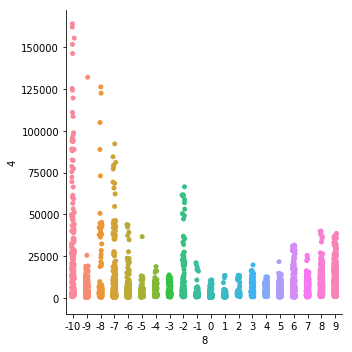

In [27]:
df = pd.DataFrame(final_arr[1:,])
sns.catplot(x=8,y=4,data=df,order=range(-10,10)) # histogram of how GDP per capita values are distributed by polity score

Z:  2.0136770564779787
P:  0.022021725193002425


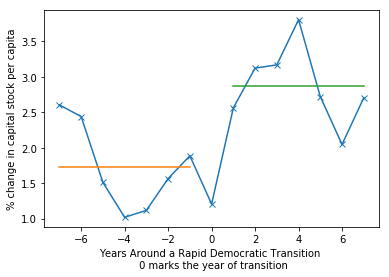

In [30]:
#uncomment one of the following options for transition_years, based on what is desired

# transition_years = np.concatenate((np.where(final_arr[:,-1]==3)[0],np.where(final_arr[:,-1]==2)[0],
#                        np.where(final_arr[:,-1]==1)[0])) # any positive democratic transition
# transition_years = np.where(final_arr[:,-1]==3)[0] # rapid democratic transitions only
transition_years = np.where(final_arr[:,-1]==2)[0] # gradual democratic transitions only
# transition_years = np.concatenate((np.where(final_arr[:,-1]==-1)[0],
#                     np.where(final_arr[:,-1]==-2)[0])) # any adverse regime transition only

analysis_period = 15 # change this to include as many or as few years as you want
transition_data = []
for j in range(transition_years.shape[0]):
    fill_arr = final_arr[range(max(1,transition_years[j]-analysis_period//2-1),min(final_arr.shape[0],transition_years[j]+1+analysis_period//2)),:]
    if fill_arr.shape[0]==analysis_period+1:
        transition_data.append(fill_arr)
transition_data = np.array(transition_data)
change_rgdppc = 100*np.divide(transition_data[:,:,4][:,1:] - transition_data[:,:,4][:,:-1],transition_data[:,:,4][:,:-1]) # calculating growth rates from per capita data
TRANSITION_DATA = reject_outliers(change_rgdppc)
X = list(range(-analysis_period//2+1,analysis_period//2+1))
avg = np.mean(TRANSITION_DATA,0)
plt.plot(X,avg,marker='x')
plt.plot(X[:7],np.repeat(np.mean(avg[:7]),7))
plt.plot(X[8:],np.repeat(np.mean(avg[8:]),7))
plt.xlabel('Years Around a Rapid Democratic Transition \n 0 marks the year of transition')
plt.ylabel('% change in capital stock per capita')

mean1 = np.mean(avg[:analysis_period//2])
mean2 = np.mean(avg[analysis_period//2+1:])
std1 = np.std(avg[:analysis_period//2])
zval = (mean2-mean1)/std1
print("Z: ",zval) # assumes null hypothesis to be no change in mean due to transition
print("P: ",scipy.stats.norm.sf(abs(zval)))

In [13]:
# optionally, next two cells are for bringing the Freedom House data to a desirable format, did not actually do 
# any analysis with it
fh = openpyxl.load_workbook('Data/Country and Territory Ratings and Statuses FIW1973-2018.xlsx')
fh = fh['Country Ratings, Statuses ']
fh_arr = []
for row in fh:
    row_data = []
    for cell in row:
        row_data.append(cell.value)
    fh_arr.append(row_data)
fh_arr = np.array(fh_arr)[3:]

In [14]:
years = list(range(1972,2018))
cl_indices = list(range(2,137,3))
countries = fh_arr[:,0]
cl_data = fh_arr[:,cl_indices]
CL_DICT = {}
for country,data in zip(countries,cl_data):
    CL_DICT[country] = data
import pandas as pd
pd.DataFrame(CL_DICT).to_csv('CivilLiberties.csv',index=False)